In [1]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sm_tsa
from random import random

# grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_rows', 10)

In [2]:
df_hospital = pd.read_csv('../data/hospital_visits.csv')
df_hospital['Week'] = df_hospital.Week.map(str) + "-" + df_hospital.Year.map(str)
df_hospital = df_hospital[['Week', 'Total ILI']]
df_hospital.columns = ['Week', 'ILI']
df_hospital = df_hospital[28:256]
df_hospital = df_hospital.reset_index(drop=True)
df_hospital

,Week,ILI
0,15-2015,12311
1,16-2015,11021
2,17-2015,11311
3,18-2015,10946
4,19-2015,9891
...,...,...
223,30-2019,7755
224,31-2019,7851
225,32-2019,8031
226,33-2019,8933


In [3]:
df_twitter = pd.read_csv('../data/twitter-flu-data.csv', header=None)
df_twitter.columns = ['Year', 'Week', '1', '2', '3', '4', '5', '6', '7']
df_twitter['Week'] = df_twitter.Week.map(str) + "-" + df_twitter.Year.map(str)
df_twitter['Tweets'] = df_twitter[['1', '2', '3', '4', '5', '6', '7']].sum(axis=1)
df_twitter = df_twitter[['Week', 'Tweets']][27:-1]
df_twitter = df_twitter.reset_index(drop=True)
df_twitter

,Week,Tweets
0,15-2015,429
1,16-2015,386
2,17-2015,352
3,18-2015,387
4,19-2015,450
...,...,...
223,30-2019,367
224,31-2019,321
225,32-2019,354
226,33-2019,292


In [4]:
df_us = pd.read_csv('../data/USA_flu_virus_counts.csv')
df_us['Week'] = df_us.Week.map(str) + "-" + df_us.Year.map(str)
df_us = df_us[['Week', 'ALL_INF']]
df_us = df_us[786+27:1042]
df_us = df_us.drop(851)
df_us = df_us.reset_index(drop=True)
df_us

,Week,ALL_INF
0,15-2015,1472
1,16-2015,1127
2,17-2015,772
3,18-2015,609
4,19-2015,527
...,...,...
223,30-2019,253
224,31-2019,248
225,32-2019,222
226,33-2019,265


In [5]:
df_aus = pd.read_csv('../data/AUS_flu_virus_counts.csv')
df_aus['Week'] = df_aus.Week.map(str) + "-" + df_aus.Year.map(str)
df_aus = df_aus[['Week', 'ALL_INF']]
df_aus = df_aus[912:1168-27]
df_aus = df_aus.drop(977)
df_aus = df_aus.reset_index(drop=True)
df_aus

,Week,ALL_INF
0,40-2014,72
1,41-2014,58
2,42-2014,29
3,43-2014,28
4,44-2014,24
...,...,...
223,3-2019,125
224,4-2019,97
225,5-2019,110
226,6-2019,106


In [6]:
list_hospital = list(df_hospital['ILI'])
list_tweets = list(df_twitter['Tweets'])
list_us = list(df_us['ALL_INF'])
list_aus = list(df_aus['ALL_INF'])

# list_tweets = [i / 5000 for i in list_tweets]
# list_hospital = [i / 50 for i in list_hospital]
# list_us = [i / 20 for i in list_us]

# list_hospital = [float(i)/sum(list_hospital) for i in list_hospital]
# list_tweets = [float(i)/sum(list_tweets) for i in list_tweets]
# list_us = [float(i)/sum(list_us) for i in list_us]
# list_aus_norm = [float(i)/sum(list_aus) for i in list_aus]

In [7]:
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(52).mean()
    rolstd = timeseries.rolling(52).std()

    #Plot rolling statistics:
    fig = plt.figure()
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

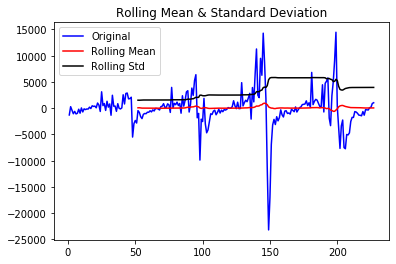

Results of Dickey-Fuller Test:
Test Statistic                  -4.328583
p-value                          0.000396
#Lags Used                       9.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


In [8]:
df_hospital['first_difference'] = df_hospital.ILI - df_hospital.ILI.shift(1)
# df_hospital['first_difference'] = df_hospital.ILI - df_hospital.ILI.shift(52)

# test_stationarity(df.first_difference.dropna(inplace=False))
test_stationarity(df_hospital.first_difference.dropna(inplace=False))

C:\Users\steph\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


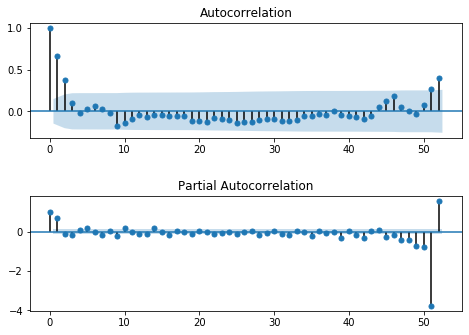

In [9]:
fig = plt.figure()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.5)
ax1 = fig.add_subplot(211)
fig = sm_tsa.plot_acf(df_hospital.first_difference.iloc[52:], lags=52, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm_tsa.plot_pacf(df_hospital.first_difference.iloc[52:], lags=52, ax=ax2)

In [10]:
list_hospital_real = list_hospital[:-52]
list_tweets_real = list_tweets[:-52]
list_us_real = list_us[:-52]
list_aus_real = list_aus[:-52]

list_hospital_pred = list_hospital[-52:]
list_tweets_pred = list_tweets[-52:]
list_us_pred = list_us[-52:]
list_aus_pred = list_aus[-52:]

In [11]:
def sarima_forecast(history, config, train_features, test_features):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, exog=train_features, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history), exog=test_features)
    return yhat[0]

def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg, features):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    train_features, test_features = train_test_split(features, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg, train_features, test_features)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error

# score a model, return None on failure
def score_model(data, n_test, cfg, features, debug=False):
    print(cfg)
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg, features)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg, features)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

In [12]:
def grid_search(data, cfg_list, n_test, features, parallel=True):
#     pred = [list_tweets_pred, list_us_pred, list_aus_pred]
#     pred = list(map(list, zip(*pred)))
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg, features) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg, features) for cfg in cfg_list]
    # remove empty results
    print(scores)
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

In [13]:
# create a set of sarima configs to try
def sarima_configs():
    models = list()
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m = 52
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                cfg = [(p,d,q), (P,D,Q,m), t]
                                models.append(cfg)
    return models

In [ ]:
# define dataset
data = list_hospital
# data split
n_test = 52
# model configs
cfg_list = sarima_configs()
print("configs done")
# grid search

features = [list_tweets, list_us, list_aus]
features = list(map(list, zip(*features)))
scores = grid_search(data, cfg_list, n_test, features)
print('done')
# list top 3 configs
for cfg, error in scores[:5]:
    print(cfg, error)

p: 0
p: 1
p: 2
configs done


In [710]:
model = SARIMAX(list_hospital_real, exog=features, enforce_stationarity=False, enforce_invertibility=False, order=(1, 1, 0), seasonal_order=(1, 1, 0, 52))
model_fit = model.fit()

In [711]:
# make prediction
future = 52
predictions = model_fit.predict(len(list_hospital_real), len(list_hospital_real) + future - 1, exog=pred)
print(predictions)
future_weeks = list(range(len(list_hospital_real), len(list_hospital_real) + future))
# future_weeks

[ 7224.84835522  7261.9628435   8049.59962733  7970.54959548
  7720.67228303 12523.6315574  12763.75254779 13642.26295044
 15538.79055506 16111.34347876 17615.25749387 19533.36617977
 16205.52943855 18874.68443738 17636.35842657 17484.45892711
 14069.24687307  7973.23180196  6608.32101468  8958.79427835
 15944.65226296 22800.17166327 32463.30053935 35292.91066609
 29315.16069914 19863.84846467 13976.13193127 13850.53682695
 11597.88955181 11598.11288805  9477.74313516 10783.74272428
  9895.83454767 10274.69026776 10878.94174813 10973.010072
 10938.85181997 11305.3376803  11138.41117355 10105.51216196
  8867.97787947  8177.08005746  8084.5725499   7114.10427993
  6470.65418369  6903.84986196  6295.75568742  6167.68663954
  6393.83088707  6077.84823064  6906.54167384  7366.65823956]


In [712]:
predictions_df = pd.DataFrame([future_weeks, predictions]).transpose()
predictions_df.columns = ['Week', 'Total ILI']
predictions_df = predictions_df.set_index('Week')

Text(0.5, 1.0, 'Total ILI + Features: 2014 - 2019')

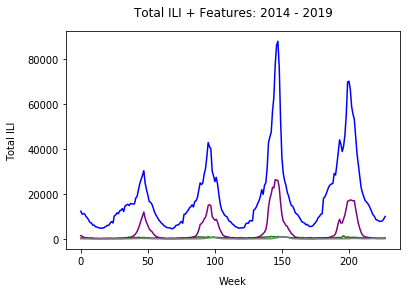

In [713]:
plt.plot(list_hospital, c='blue')
plt.plot(list_tweets, c='green')
plt.plot(list_us, c='purple')
plt.plot(list_aus, c='gray')
# plt.plot(predictions_df, '--', c='#1f77b4')
plt.xlabel("Week", labelpad=10)
plt.ylabel("Total ILI", labelpad=10)
plt.title("Total ILI + Features: 2014 - 2019", pad=15)

Text(0.5, 1.0, 'Total ILI: 2014 - 2019 + predictions')

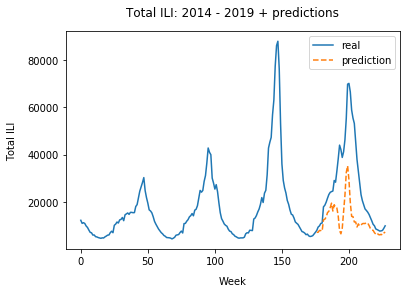

In [714]:
plt.plot(df_hospital['ILI'], label='real')
# plt.plot(predictions_df)
plt.plot(predictions_df, '--', label='prediction')
plt.legend()
plt.xlabel("Week", labelpad=10)
plt.ylabel("Total ILI", labelpad=10)
plt.title("Total ILI: 2014 - 2019 + predictions", pad=15)

In [709]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  176
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 52)   Log Likelihood               -1073.041
Date:                            Mon, 09 Dec 2019   AIC                           2162.082
Time:                                    15:14:09   BIC                           2184.580
Sample:                                         0   HQIC                          2171.221
                                            - 176                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     19.5480    727.625      0.027      0.979   -1406.570    1445.666
drift         -0.1258      5.717     -0.022      0.982     -11.330      11.078
x1            -0.9499      1.554     -0.611      0.541      -3.996       2.096
x2             2.1514      0.081     26.626      0.000       1.993       2.310
x3             0.7968      2.734      0.291      0.771      -4.562       6.156
ar.L1          0.4951      0.055      8.979      0.000       0.387       0.603
ar.S.L52      -0.0931      0.103     -0.908      0.364      -0.294       0.108
sigma2      2.228e+06   1.93e+05     11.535      0.000    1.85e+06    2.61e+06
===================================================================================
Ljung-Box (Q):                       35.91   Jarque-Bera (JB):               187.71
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               5.46   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""